# Validation

Validation cases of CCBlade's functionalities.

In [1]:
using CCBlade

## Distributed Load - Ballard's Rotor

* **Description:** Comparison of CCBlade's predicted distributed load to experimental data on a rotor of simple geometry.
* **Data source:** Ballard, J. D., Orloff, K. L., & Luebs, A. B. (1979). Effect of Tip Planform on Blade Loading Characteristics for a Two-Bladed Rotor in Hover. Figures 9 and 10 (see images below).
* **Configuration:** Rectangular two-bladed rotor. Tip Reynolds number of $4\times10^5$ and Mach number of 0.22 at 700 RPM. Static test (no inflow other than induced). Collective pitch of $9.8^\circ$

|  |  |
| ------ | ----------- |
| <figure><img src="figures/ballard00.png" alt="Pic here" width="350px"/><figcaption> </figcaption></figure>   | <figure><img src="figures/ballard01.png" alt="Pic here" width="350px"/><figcaption> </figcaption></figure> |
| <figure><img src="figures/ballard04.png" alt="Pic here" width="350px"/><figcaption> </figcaption></figure>   | <figure><img src="figures/ballard05.png" alt="Pic here" width="350px"/><figcaption> </figcaption></figure> |

### Setup

In [2]:
import CSV
using PyPlot

# ------------------ SIMULATION SETUP ----------------------

# Operation parameters
rho = 1.225             # (kg/m^3) air density
Vinf = 0.0              # (m/s) freestream
Omega = 73.3            # (rad/s) rotor angular speed
pitch = 9.8             # (deg) blade pitch

# Geometric parameters
B = 2                   # Number of blades
Rtip = 1.05             # (m) blade radius
Rhub = 0.134*Rtip       # (m) hub radius
twistroot = 6.5         # (deg) twist at root
twisttip = -3.0         # (deg) twist at tip
chordroot = 0.0726*Rtip # (m) chord at root
chordtip = 1.0*chordroot# (m) chord at tip
precone = 1.5*pi/180    # (rad) blade precone
n = 30                  # Number of elements (not including tip and root)

# Geometry definition
                                                # Radial positions
r = [Rhub + i*(Rtip-Rhub)/(n+1) for i in 0:n+1 if !(i in [0, n+1])]
                                                # Chord at each position
chord = [chordroot + (chordtip-chordroot)*(ri-Rhub)/(Rtip-Rhub) for ri in r]
                                                # (rad) eff twist at each position
theta = pitch + [twistroot + (twisttip-twistroot)*(ri-Rhub)/(Rtip-Rhub) for ri in r]
theta = pi/180.0*theta
af = Array{AirfoilData}(n)                      # Airfoil properties
            
for i in 1:n
    # Reads the airfoil data that has been pre-calculated with airfoilprep.py
    r_over_R = Int(round(r[i]/Rtip, 3)*1000)
    c_over_r = Int(round(chord[i]/r[i], 3)*1000)
                
    # Read file
    file_name = "roR$r_over_R-$cor$c_over_r-tsrNull"
    file_name = "naca0012-"*file_name*".csv"
    data = CSV.read(joinpath("airfoils/naca0012",file_name), datarow=2)
    
    # Convert to AirfoilData object
    af[i] = af_from_data(data[1], data[2], data[3])
end

# Inflow definition
inflow = simpleinflow(Vinf, Omega, r, precone, rho)
            
# Rotor definition
rotor = Rotor(r, chord, theta, af, Rhub, Rtip, B, precone)
            
# ------------------ RUN CCBLADE ---------------------------
turbine = false
Np, Tp, uvec, vvec = distributedloads(rotor, inflow, turbine);

### Verification

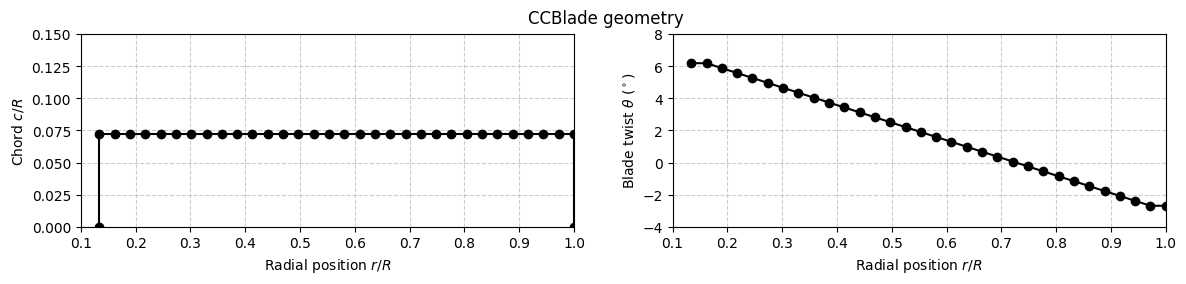

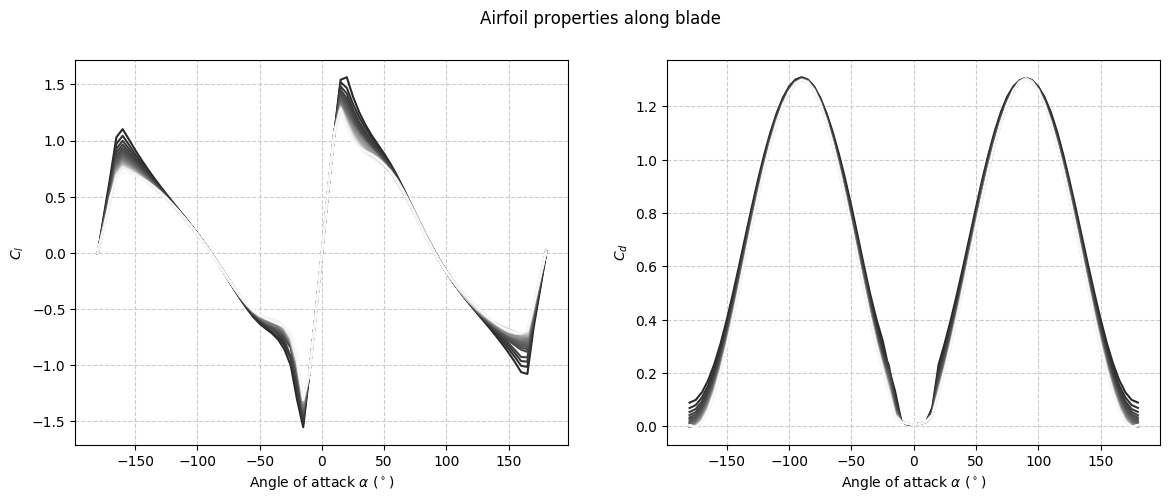

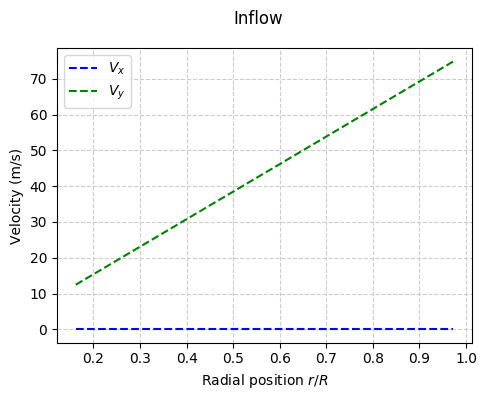

In [3]:
            
# ------------------ PLOTS ---------------------------------
            
# Plots geometry for verification
fig0 = figure("geometry", figsize=(7*2, 2.5*1))
suptitle("CCBlade geometry")

## Chord along blade
subplot(121)
plot(vcat([rotor.Rhub, rotor.Rhub], rotor.r, [rotor.Rtip, rotor.Rtip])/rotor.Rtip, 
    vcat([0, rotor.chord[1]], rotor.chord, [rotor.chord[end], 0])/rotor.Rtip, "o-k")
xlim([0.1, 1])
ylim([0, 0.15])
xlabel(L"Radial position $r/R$")
ylabel(L"Chord $c/R$")
grid(true, color="0.8", linestyle="--")

## Twist along blade
subplot(122)
plot(vcat([rotor.Rhub], rotor.r, [rotor.Rtip])/rotor.Rtip, 
    vcat([rotor.theta[1]], rotor.theta, [rotor.theta[end]])*180/pi-pitch, "o-k")
xlim([0.1, 1])
ylim([-4, 8])
xlabel(L"Radial position $r/R$")
ylabel(L"Blade twist $\theta$ ($^\circ$)")
grid(true, color="0.8", linestyle="--")



# Plots airfoil data used at each radial position
alphas = [i for i in -180:5:180]
fig1 = figure("airfoil_data", figsize=(7*2, 5*1))
suptitle("Airfoil properties along blade")
            
for (i,this_af) in enumerate(af)
    subplot(121)
    plot(alphas, [this_af.cl(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
    subplot(122)
    plot(alphas, [this_af.cd(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
end
            
subplot(121)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_l")
grid(true, color="0.8", linestyle="--")
subplot(122)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_d")
grid(true, color="0.8", linestyle="--")
          


# Plots inflow
fig3 = figure("inflow", figsize=(7*0.765, 5*0.765))
suptitle("Inflow")

subplot(111)
plot(rotor.r/rotor.Rtip, inflow.Vx, "--b", label=L"V_x")
plot(rotor.r/rotor.Rtip, inflow.Vy, "--g", label=L"V_y")
xlabel(L"Radial position $r/R$")
ylabel("Velocity (m/s)")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

### Results

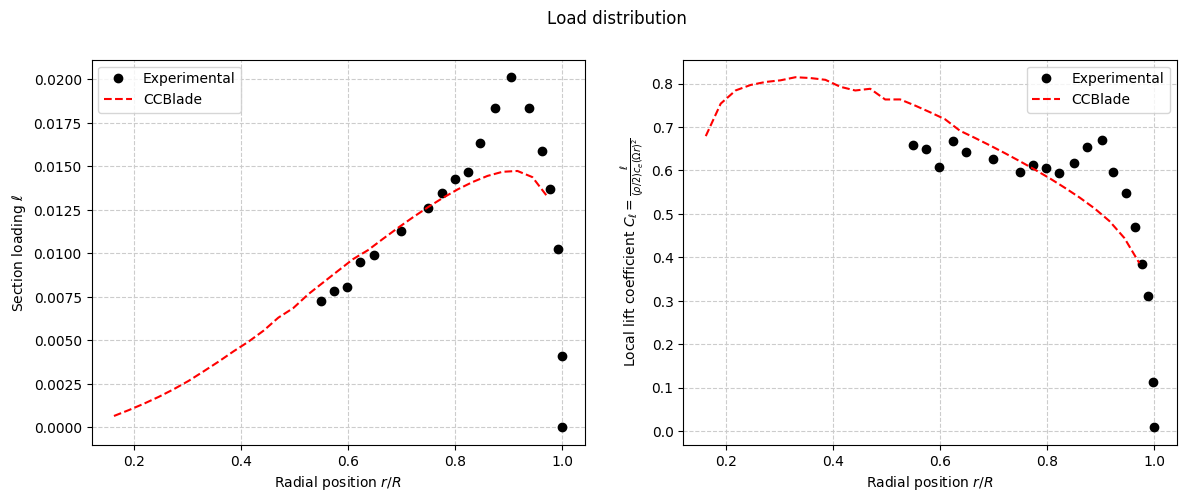

In [4]:
# Plots experimental vs CCBlade

## Reads experimental
exp_data_l = CSV.read("data/ballard-l.csv", datarow=1)
exp_data_cl = CSV.read("data/ballard-cl.csv", datarow=1)
            
## Nondimensionalizes CCBlade
ccb_data_l = zeros(Float64, n, 2)
ccb_data_l[:, 1] = r/Rtip
non_dim_l = rho*Omega^2*Rtip^3
ccb_data_l[:, 2] = Np./non_dim_l

ccb_data_cl = zeros(Float64, n, 2)
ccb_data_cl[:, 1] = r/Rtip
non_dim_cl = (rho/2)*mean(chord)*(Omega*r).^2
ccb_data_cl[:, 2] = Np./non_dim_cl

## Plots
fig2 = figure("load_distribution", figsize=(7*2, 5*1))
suptitle("Load distribution")
            
subplot(121)
plot(exp_data_l[1], exp_data_l[2], "ok", label="Experimental")
plot(ccb_data_l[:, 1], ccb_data_l[:, 2], "--r", label="CCBlade")
xlabel(L"Radial position $r/R$")
ylabel(L"Section loading $\ell$")
legend(loc="best")
grid(true, color="0.8", linestyle="--")
            
subplot(122)
plot(exp_data_cl[1], exp_data_cl[2], "ok", label="Experimental")
plot(ccb_data_cl[:, 1], ccb_data_cl[:, 2], "--r", label="CCBlade")
xlabel(L"Radial position $r/R$")
ylabel(L"Local lift coefficient $C_\ell = \frac{\ell}{(\rho/2)c_e(\Omega r)^2}$")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

The section loading $\ell$ compares relatively well with the prescribed-wake method analyzed in Ballard's report:

|  |  |
| ------ | ----------- |
| <figure><img src="figures/ballard02.png" alt="Pic here" width="500px"/><figcaption> </figcaption></figure>   | <figure><img src="figures/ballard03.png" alt="Pic here" width="600px"/><figcaption> </figcaption></figure> |

From the Kutta–Joukowski theorem, the circulation around the airfoil cross section at each radial position can be calculated as

\begin{align}
    \Gamma = -\frac{\ell}{\rho V_\infty}
,\end{align}
where $V_\infty$ is the inflow at each radial position.

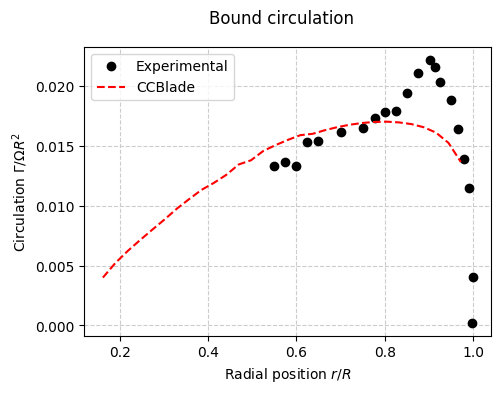

In [16]:

## Reads experimental
exp_data_gamma = CSV.read("data/ballard-gamma.csv", datarow=1)
            
## Nondimensionalizes CCBlade
ccb_data_gamma = zeros(Float64, n, 2)
ccb_data_gamma[:, 1] = r/Rtip
non_dim_gamma = Omega*Rtip^2
ccb_data_gamma[:, 2] = Np./(rho*inflow.Vy) ./ non_dim_gamma

## Plots
fig4 = figure("circulation", figsize=(7*0.75, 5*0.75))
suptitle("Bound circulation")
            
subplot(111)
plot(exp_data_gamma[1], exp_data_gamma[2], "ok", label="Experimental")
plot(ccb_data_gamma[:, 1], ccb_data_gamma[:, 2], "--r", label="CCBlade")
xlabel(L"Radial position $r/R$")
ylabel(L"Circulation $\Gamma/\Omega R^2$")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

**Conclusion:** Good prediction of section loading towards the center of the blade, but poor prediction towards the tip.

## Sketchbook (Ignore this)

In [5]:
run_this = false

if run_this
    include("../../airfoil/src/airfoilprep.jl")
    ap = airfoilprep

    println(pwd())
    polar = ap.read_polar("xf-n0012-il-500000-n5.csv"; path="airfoils")

    tsr = nothing
    for (i,ri) in enumerate(r)
        r_over_R = ri/Rtip
        c_over_r = chord[i]/ri

        this_polar = ap.correction3D(polar, r_over_R, chord[i]/ri, nothing)
        this_polar = ap.extrapolate(this_polar, 1.3)
        this_polar = ap.injective(this_polar)

        file_name = "naca0012-roR$(Int(round(r_over_R,3)*1000))-cor$(Int(round(c_over_r,3)*1000))"
        file_name *= "-tsr$(tsr==nothing ? "Null" : Int(round(tsr,3)*1000))"
        ap.save_polar2(this_polar, file_name, path="airfoils/naca0012")
    end


    this_polar = ap.extrapolate(polar, 1.3)
    ap.save_polar2(this_polar, "naca0012-orig", path="airfoils/naca0012")
end